# Trabalho Prático #1

**Grupo:**

- Lucas Jacone da Silva - 2019006922

- Filipe Rodrigues Batista de Oliveira - 2018055091

- Matheus Flávio Gonçalves Silva - 2020006850

In [217]:
from functools import cmp_to_key
import matplotlib.pyplot as plt
import numpy as np

## ***Implementação***

Por Python ser uma linguagem bem expressiva o código abaixo ficou muito parecido com os pseudo-códigos consultados no livro *Introduction of Algorithms - Cormen et al*.

## Parte I

In [218]:
class Ponto:
  """ Ponto de duas dimensões """

  def __init__(self, x, y):
    self.x = x
    self.y = y

  # Overload do operador - para subtração entre pontos
  def __sub__(self, p2):
    return Ponto(self.x - p2.x, self.y - p2.y)

In [219]:
def distancia(p1, p2):
  """ Retorna o quadrado da distância entre dois pontos """

  return (p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2

In [220]:
def produtoVetorial(p0, p1, p2):
  """ Retorna o ponto da terceira dimensão de um produto vetorial
     entre dois pontos """

  return (p1.x - p0.x) * (p2.y - p0.y) - (p2.x - p0.x) * (p1.y - p0.y)

Para descobrir o sentido que o segmento p0p2 estaria de p0p1 nós fazemos o cálculo do produto vetorial, e caso os segmentos sejam colineares (pv = 0), então temos que encontrar qual o ponto mais distante dentre os dois, já que o ponto mais perto invariavelmente estará dentro da envoltória.

In [221]:
def comparaSentido(p1, p2):
  """ Função de comparação para ordenar os pontos quanto ao ângulo polar
 em relação a 'p0' utilizando o produto vetorial """

  pv = produtoVetorial(p0, p1, p2)

  if pv == 0:
    return 1 if distancia(p0, p1) > distancia(p0, p2) else -1

  return -1 if pv > 0 else 1

Embora tenham sido vistos em sala de aula mais dois algoritmos que resolvessem o mesmo problema com a mesma complexidade de tempo $O(n \log n)$: Algoritmo incremental e o Algoritmo dividir para conquistar, optou-se por implementar a Varredura de Graham (presente na função "envoltoriaConvexa"), pois os autores pensaram que esta fosse mais fácil de se implementar do que as outras.


In [222]:
def envoltoriaConvexa(pontos):
  """ Dado como entrada uma lista de ´pontos´ retorna a lista de pontos
 pertencentes à mesma envoltória convexa """

  # Checa se há pontos suficientes para formar uma envoltória
  quantidade = len(pontos)
  if quantidade < 3:
    return []

  # Define p0 como o ponto com menor 'y' desempatado pelo menor 'x'
  pontos.sort(key=lambda p: (p.y, p.x))

  envoltoria = []
  global p0
  p0 = pontos[0]
  envoltoria.append(p0)

  # Ordena os outros pontos de acordo com seu ângulo polar em relação a p0
  # Como já havia sido ordenado anteriormente com relação a y e x, pontos
  # colineares estão ordenados crescentemente em relação à distância
  pontos[1:] = sorted(pontos[1:], key = cmp_to_key(comparaSentido))

  # Cria uma nova lista sem pontos colineares em relação a p0
  # (mantém o mais distante)
  pontos_validos = [p0, pontos[1]]
  for i in range(2, quantidade):
    if produtoVetorial(p0, pontos[i], pontos[i-1]) == 0:
      pontos_validos[-1]=pontos[i]
    else:
      pontos_validos.append(pontos[i])

  # Checa se há pontos suficientes para formar uma envoltória
  if len(pontos_validos) < 3:
    return []

  # Constrói uma envoltória inicial com os primeiros 3 pontos sem
  # colinearidade
  envoltoria.append(pontos_validos[1])
  envoltoria.append(pontos_validos[2])

  # Adiciona os pontos restantes na envoltória, checando a consistência da
  # convexidade
  for p in pontos_validos[3:]:
    while(produtoVetorial(envoltoria[-2], envoltoria[-1], p) < 0):
      envoltoria.pop(-1)
    envoltoria.append(p)

  return envoltoria

## Parte II

Aqui, cabe explicar a lógica utilizada para fazer a sobrecarga do operador '<' (que será utilizado para fazer comparar segmentos adjacentes no algoritmo de varredura): Sendo que os critérios usados para definir a ordem são (da maior prioridade para a menor):

1 - Ponto do início do segmento (pontos da esquerda) está mais abaixo (menor coordenada y);

2 - Pontos do início do segmento são os mais à esquerda;

3 - Ponto do final do segmento está mais abaixo;

4 - Ponto do final do segmento está mais à esquerda;

Veja que para usar a quarta condição (como desempate) nós estamos no caso limite, ou seja, se dois segmentos são colineares.

In [223]:
class Segmento:
  """ Segmento formado entre dois pontos, sendo que 'esquerda' é o ponto
   de menor x """

  def __init__(self, esquerda, direita):
    self.esquerda = esquerda
    self.direita = direita

  def __lt__(self, e2):
    """ Overload do operador '<' para encontrar a posição relativa entre segmentos
        ativos na varredura """

    if self.esquerda.y == e2.esquerda.y:
      if self.esquerda.x == e2.esquerda.x:
        if self.direita.y == e2.direita.y:
          return self.direita.x < e2.direita.x
        return self.direita.y < e2.direita.y
      return self.esquerda.x < e2.esquerda.x
    return self.esquerda.y < e2.esquerda.y

Na sobrecarga do operador '<' da classe Evento (pontos encontrados pela reta de varredura) implementamos a lógica para inserir os eventos na varredura, ou seja, buscamos o ponto mais a esquerda (com menor coordenada x) primeiro, caso haja empate buscamos o ponto mais abaixo (com menor coordenada y).

In [224]:
class Evento:
  """ Os pontos de inserção ou remoção de um segmento na varredura linear """

  def __init__(self, x, y, isLeft, s, classe):
    self.x = x
    self.y = y
    self.isLeft = isLeft
    self.s = s
    self.classe = classe

  def __lt__(self, e2):
    """ Overload do operador '<' para encontrar a ordem que os eventos devem ser
        inseridos na varredura """

    if self.x == e2.x:
      if self.isLeft == e2.isLeft:
        return self.y < e2.y
      return self.isLeft
    return self.x < e2.x

In [225]:
def noSegmento(p1, p3, p2):
  """ Checa se um ponto 'p2' está sobre o segmento 'p1p3' """

  return (p2.x <= max(p1.x, p3.x) and p2.x >= min(p1.x, p3.x) and
          p2.y <= max(p1.y, p3.y) and p2.y >= min(p1.y, p3.y))

Aqui nós implementamos o algoritmo para verificar se existe interseção entre dois segmentos, usando as primitivas implementadas em células anteriores como suporte.

In [226]:
def segmentosIntersectam(s1, s2):
  """ Checa se dois segmentos 's1' e 's2' se interceptam """

  p1 = s1.esquerda
  p2 = s1.direita
  p3 = s2.esquerda
  p4 = s2.direita

  pv1 = produtoVetorial(p3, p4, p1)
  pv2 = produtoVetorial(p3, p4, p2)
  pv3 = produtoVetorial(p1, p2, p3)
  pv4 = produtoVetorial(p1, p2, p4)

  # Checa se os segmentos formam um "X"
  if ((pv1>0 and pv2<0 or pv1<0 and pv2>0) and
      (pv3>0 and pv4<0 or pv3<0 and pv4>0)):
    return True

  # Checa se um dos pontos de um segmento está sobre outro segmento
  if pv1 == 0 and noSegmento(p3, p4, p1):
    return True
  if pv2 == 0 and noSegmento(p3, p4, p2):
    return True
  if pv3 == 0 and noSegmento(p1, p2, p3):
    return True
  if pv4 == 0 and noSegmento(p1, p2, p4):
    return True

  return False

In [227]:
def lowerBound(varredura, e):
  """ Encontra o índice do primeiro evento na varredura que não é menor
      que 'e' """

  ini = 0
  fim = len(varredura) - 1

  while(ini < fim):
    meio = (ini + fim) // 2

    if varredura[meio].s < e.s:
      ini = meio + 1
    else:
      fim = meio

  return ini

In [228]:
def upperBound(varredura, e):
  """ Encontra o índice do último evento na varredura que não é maior
       que 'e' """

  ini = 0
  fim = len(varredura) - 1

  while(ini < fim):
    meio = (ini + fim) // 2

    if varredura[meio].s > e.s:
      fim = meio
    else:
      ini = meio + 1

  return ini

In [229]:
def inserirEvento(varredura, e):
  """ Insere um evento 'e' na varredura """

  # Checa se a varredura está vazia
  if len(varredura) == 0:
      varredura.insert(0, e)

  # Checa se o evento deve ser o primeiro ou segundo da varredura
  elif lowerBound(varredura, e) == 0 and varredura[0].s > e.s:
      varredura.insert(0, e)
  else:
    varredura.insert(lowerBound(varredura, e) + 1, e)

  return

In [230]:
def removerEvento(varredura, e):
  """ Remove um evento na varredura """

  # Encontra o evento correspondente à extremidade da esquerda do evento 'e' que
  # foi inserido, tendo em vista que o evento 'e' é a extremidade da direita de
  # um segmento
  inserido = Evento(e.s.esquerda.x, e.s.esquerda.y, 1, e.s, e.classe)

  # Deleta esse evento
  del varredura[lowerBound(varredura, inserido)]
  return

In [231]:
def eventoAnterior(varredura, e):
  """ Encontra o evento na varredura logo abaixo de um evento 'e' """

  # Checa se a varredura está vazia
  if len(varredura) == 0:
    return None

  # Encontra o possível índice do evento anterior
  indice = lowerBound(varredura, e)

  # Checa se esse evento anterior existe
  if indice == 0 and varredura[0] == e:
    return None

  return varredura[indice]

In [232]:
def eventoPosterior(varredura, e):
  """ Encontra o evento na varredura logo acima de um evento 'e' """

  # Checa se a varredura está vazia
  if len(varredura) == 0:
    return None

  # Encontra o possível índice do evento posterior
  indice = upperBound(varredura, e)

  # Checa se esse evento posterior existe
  if indice == len(varredura)-1:
    return None

  return varredura[indice+1]

In [233]:
def segmentosDaEnvoltoria(env):
  """ Encontra quais segmentos compoem uma envoltória a partir da ordem
  de seus vértices """

  segmentos = []

  # Segmento entre o primeiro e o último ponto da envoltória
  p1 = env[0]
  p2 = env[-1]

  # Verifica qual ponto do segmento deve ser 'esquerda' e qual 'direita'
  if p1.x < p2.x:
    segmentos.append(Segmento(p1, p2))
  else:
    segmentos.append(Segmento(p2, p1))

  # Repete para todo par de vértices consecutivos
  for i in range(1, len(env)):
    p1 = env[i]
    p2 = env[i-1]

    # Verifica qual ponto do segmento deve ser 'esquerda' e qual 'direita'
    if p1.x < p2.x:
      segmentos.append(Segmento(p1, p2))
    else:
      segmentos.append(Segmento(p2, p1))

  return segmentos

In [234]:
def criarEventos(segmentos1, segmentos2):
  """ Encontra a ordem em que os segmentos de duas envoltórias devem ser
      inseridos ou removidos da varredura """

  eventos = []

  # Repete para todo segmento na envoltória 1
  for seg in segmentos1:

    # Cria o evento de inserção do segmento
    e1 = Evento(seg.esquerda.x, seg.esquerda.y, 1, seg, 1)
    eventos.append(e1)

    # Cria o evento de remoção do segmento
    e2 = Evento(seg.direita.x, seg.direita.y, 0, seg, 1)
    eventos.append(e2)

  # Repete para todo segmento na envoltória 2
  for seg in segmentos2:

    # Cria o evento de inserção do segmento
    e1 = Evento(seg.esquerda.x, seg.esquerda.y, 1, seg, 2)
    eventos.append(e1)

    # Cria o evento de inserção do segmento
    e2 = Evento(seg.direita.x, seg.direita.y, 0, seg, 2)
    eventos.append(e2)

  # Ordena os eventos utilizando o operador sobrecarregado '<'
  return sorted(eventos)

Para a verificação da separabilidade linear, foi utilizada a detecção de interseções em um conjunto de segmentos por meio de uma varredura linear que compara um segmento apenas com os segmentos diretamente superiores e inferiores ao inserí-lo na varredura e compara os segmentos diretamente superiores e inferiores entre si ao remover um segmento.

Há uma modificação que determina que ao tentar comparar dois segmentos de uma mesma envoltória, essa comparação é ignorada e é feita outra comparação entre o próximo par tal que os dois segmentos pertencem a envoltórias diferentes. Essa implementação está na função "intersecaoEmConjuntos", que retorna True se há interseção entre as envoltórias e, portanto, não é possível fazer uma separação linear, e retorna False caso contrário.

In [235]:
def intersecaoEmConjunto(eventos):
  """ Função que retorna se houve ou não interseção entre os lados de duas
      envoltórias convexas """
  varredura = []

  # Repete para cada evento de inserção ou remoção na varredura
  for evento_atual in eventos:

    # Se o evento é de inserção
    if evento_atual.isLeft:

      # Encontra o evento logo abaixo
      evento_anterior = eventoAnterior(varredura, evento_atual)

      # Encontra o evento logo acima
      evento_posterior = eventoPosterior(varredura, evento_atual)

      # Insere o segmento na varredura
      inserirEvento(varredura, evento_atual)

      # Compara o evento inserido com o evento logo abaixo
      if (evento_anterior is not None and
          evento_anterior.classe!=evento_atual.classe):
        if segmentosIntersectam(evento_anterior.s, evento_atual.s):
          return True

      # Compara o evento inserido com o evento logo acima
      if (evento_posterior is not None and
          evento_posterior.classe!=evento_atual.classe):
        if segmentosIntersectam(evento_posterior.s, evento_atual.s):
          return True

    # Se o evento é de remoção
    else:
      # Remove o segmento da varredura
      removerEvento(varredura, evento_atual)

      # Encontra o evento logo abaixo
      evento_anterior = eventoAnterior(varredura, evento_atual)

      # Encontra o evento logo acima
      evento_posterior = eventoPosterior(varredura, evento_atual)

      # Compara o evento logo abaixo e o evento logo acima
      if (evento_anterior is not None and evento_posterior is not None and
          evento_anterior.classe!=evento_posterior.classe):
        if segmentosIntersectam(evento_anterior.s, evento_posterior.s):
          return True

  return False

## Parte III

In [236]:
# Função para plotar duas envoltórias
def plotarParDeEnvoltorias(env1, env2):
  fig, ax = plt.subplots()
  fig.set_size_inches(5, 3.5)
  ax.plot([env1[0].x, env1[len(env1)-1].x],
          [env1[0].y, env1[len(env1)-1].y], 'bo-', label = 'Envoltória 1')
  for i in range(1, len(env1)):
    plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

  ax.plot([env2[0].x, env2[len(env2)-1].x],
          [env2[0].y, env2[len(env2)-1].y], 'ro-', label = 'Envoltória 2')
  for i in range(1, len(env2)):
    plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

  return fig, ax

## Partes IV e V

A função **encontrarVerticesMaisProximos** recebe dois conjuntos de pontos representando envoltórias convexas e um parâmetro opcional plotar que controla a visualização gráfica.

A função inicialmente encontra os pontos mais abaixo da envoltória 1 e mais acima da envoltória 2 com base em suas coordenadas $y$. Esses pontos são definidos como os pontos iniciais na análise. Assim, são analisados os pontos atuais nas envoltórias e calcula a distância entre eles. É encontrado também o segmento de menor distância.

Essa implementação realiza iterações sobre os pontos nas envoltórias considerando todos os possíveis pares de pontos e encontra o segmento de menor distância.

O segmento de menor distância e os índices dos pontos nas envoltórias correspondentes são retornados como resultado.

Em suma, é executada a técnica de varredura das envoltórias e cálculo de distância para encontrar os dois pontos mais próximos entre duas envoltórias convexas.

In [237]:
def encontrarVerticesMaisProximos(env1, env2, plotar=False):
  # Plota as duas envoltórias
  if plotar:
    fig, ax = plotarParDeEnvoltorias(env1, env2)

  # Encontra o índice do ponto mais abaixo da envoltória 1 e do ponto mais acima
  # da envoltória 2 e os define como os primeiros pontos na análise
  p1 = sorted(env1, key=lambda p: (p.y, p.x))[0]
  p2 = sorted(env2, key=lambda p: (p.y, p.x))[-1]
  inicial1 = env1.index(p1)
  inicial2 = env2.index(p2)
  atual1 = inicial1
  atual2 = inicial2
  visitados1 = 0
  visitados2 = 0

  # Plota o segmento sendo analisado na iteração
  if plotar:
    ax.plot([p1.x, p2.x], [p1.y, p2.y], 'ko-')
    ax.legend()
    plt.show()

  # Inicializa o segmento de menor distância até então
  distancia_min = distancia(env1[atual1], env2[atual2])
  segmento_min = Segmento(env1[atual1], env2[atual2])
  indice_min_env1 = atual1
  indice_min_env2 = atual2

  # Encontra próximo segmento a ser analizado
  proximo1 = atual1+1 if atual1!=len(env1)-1 else 0
  proximo2 = atual2+1 if atual2!=len(env2)-1 else 0
  if produtoVetorial(Ponto(0, 0), env1[atual1]-env1[proximo1],
                    env2[atual2]-env2[proximo2]) < 0:
    atual2 = proximo2
    visitados2+=1
  else:
    atual1 = proximo1
    visitados1+=1

  # Repete até passar por todos os pares possíveis
  while(visitados1<=len(env1) and visitados2<=len(env2)):
    # Plota as duas envoltórias e o segmento sendo analisado na iteração
    if plotar:
      fig, ax = plotarParDeEnvoltorias(env1, env2)

      ax.plot([env1[atual1].x, env2[atual2].x],
              [env1[atual1].y, env2[atual2].y], 'ko-')

      ax.legend()
      plt.show()

    # Verifica se a distância atual é a menor calculada até então
    if distancia(env1[atual1], env2[atual2]) < distancia_min:
      distancia_min = distancia(env1[atual1], env2[atual2])
      segmento_min = Segmento(env1[atual1], env2[atual2])
      indice_min_env1 = atual1
      indice_min_env2 = atual2

    # Encontra próximo segmento a ser analizado
    proximo1 = atual1+1 if atual1!=len(env1)-1 else 0
    proximo2 = atual2+1 if atual2!=len(env2)-1 else 0
    if produtoVetorial(Ponto(0, 0), env1[atual1]-env1[proximo1],
                      env2[atual2]-env2[proximo2]) > 0:
      atual2 = proximo2
      visitados2+=1
    else:
      atual1 = proximo1
      visitados1+=1

  return segmento_min, indice_min_env1, indice_min_env2

No caso em que há separabildiade linear entre os dados, são localizados os pontos mais próximos entre as duas envoltórias e a reta perpendicular ao ponto médio.

Para tal, usamos a declaração da classe auxiliar **Reta** para melhor manipulação dos atributos da reta específica.
É composta simplesmente pelos artibutos $a$, que representa a inclinação, e $b$, que é o termo independente, ambos de acordo com a equação da reta $f(x) = a*x + b$.

A reta perpendicular é calculada e estruturada pela função **retaPerpendicular** sendo utilizados conceitos matemáticos básicos, recebendo como entrada a reta original e o ponto em que a reta perpendicular e a original se intersecionam.

Acresce o uso da funções **retaDoSegmento** que encontra a reta que contém o segmento passado como parâmetro, **funcaoDaReta** que retorna o valor número da função $y(x)$ para um dado $x$ passado e **pontoDeInteresecao**, que encontra o ponto de interseção entre duas retas $reta1$ e $reta2$ caso exista.

In [238]:
# Classe de uma reta y = ax + b
class Reta:
  def __init__(self, a, b):
    self.a = a
    self.b = b

In [239]:
# Encontra a reta y' = a'x + b' perpendicular a uma reta r
# que passe por um ponto p
def retaPerpendicular(r, p):
  # Inclinação da reta (a')
  a2 = -1/r.a
  # Desvio vertical em relação à origem (b')
  b2 = p.y - a2*p.x

  r2 = Reta(a2, b2)
  return r2

In [240]:
# Encontra a reta y = ax + b que contém o segmento s
def retaDoSegmento(s):
  # Inclinação da reta (a)
  if (s.esquerda.x-s.direita.x) == 0:
    a = np.Inf
  else:
    a = (s.esquerda.y-s.direita.y)/(s.esquerda.x-s.direita.x)
  # Desvio vertical em relação à origem (b)
  b = s.esquerda.y - a*s.esquerda.x

  r = Reta(a, b)
  return r

In [241]:
# função y(x) da reta y = ax + b
def funcaoDaReta(r):
  # Define a função da reta e a retorna
  def f(x):
    return r.a*x + r.b

  return f

In [242]:
# Encontra o ponto de interseção entre duas retas
def pontoDeIntersecao(reta1, reta2):
  x = (reta2.b - reta1.b)/(reta1.a - reta2.a)

  f = funcaoDaReta(reta1)

  return Ponto(x, f(x))

# Parte VI

In [243]:
from sklearn.metrics import precision_score, recall_score, f1_score

## ***EXPERIMENTOS***

De forma a satisfazer a especificação do trabalho, para cada base de dados usada, nós primeiro filtramos as variáveis de forma a termos apenas 2 variáveis.

# Experimento 1 - Iris plants dataset

In [244]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/iris.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[2,3]], axis=1, inplace=True)
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)
classe1 = ' Iris-setosa'
classe2 = ' Iris-versicolor'

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] == classe1:
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == classe2:
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

# Parte 1

In [245]:
# Encontra a envoltória convexa dos pontos da classe1
env1 = envoltoriaConvexa(pontos1)

In [246]:
# Encontra a envoltória convexa dos pontos da classe2
env2 = envoltoriaConvexa(pontos2)

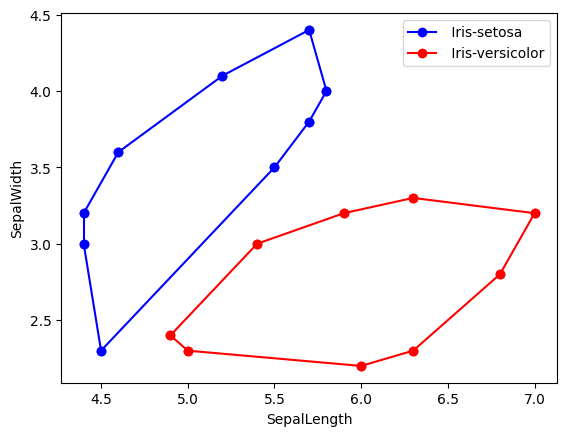

In [247]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = classe1)
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = classe2)
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("SepalLength")
plt.ylabel("SepalWidth")
plt.legend()
plt.show()

# Parte 2


In [248]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

In [249]:
# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

# Parte 3

In [250]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados linearmente separáveis


# Parte 4
A construção do modelo leva em consideração o algoritmo de Gilbert–Johnson–Keerthi para detectar colisões, mais especificamente o cálculo da diferença de Minowski para encontrar, para cada ângulo em duas dimensões possível de um vetor, os dois pontos mais próximos e os dois pontos mais distantes entre dois polígonos segundo tal vetor.

Nessa aplicação, foi utilizado como estado inicial da busca o ponto na envoltória 1 com maior y e o ponto na envoltória 2 com menor y, o que seriam os dois pontos mais distantes ou mais próximos considerando um vetor vertical. Em seguida o algoritmo iterativamente encontra os próximos pares de pontos, de forma que os pontos sempre são de envoltórias diferentes. É escolhido o par de pontos cuja distância euclidiana é a menor de todas como o par A, D de vértices mais próximos entre as envoltórias. Essa busca iterativa pode ser observada graficamente na função "encontrarVerticesMaisProximos" desde que a flag "plotar" esteja com o valor True.

Seja A o vértice na envoltória 1 e D o vértice na envoltória 2. B e C são vértices tal que AB e AC são lados da envoltória 1 e E e F são vértices tal que DE e DF são lados da envoltória 2. Utilizando esses vértices, o algoritmo encontra a altura dos triângulos ABD, ACD, ADE, ADF. Em seguida, o algoritmo escolhe apenas os triângulos que são acutângulos e compara a altura desses triângulos com a distância entre A e D e escolhe o menor desses segmentos como sendo a menor distância entre as envoltórias.

Por fim, para definir a reta de classificação, o algoritmo encontra a reta perpendicular a esse segmento que passa pelo ponto médio do segmento.

In [251]:
# Encontra os vértices de menor distância entre as envoltórias
segmento_min, indice_min_env1, indice_min_env2 = encontrarVerticesMaisProximos(env1, env2, plotar=False)

In [252]:
# Encontra os pontos na envoltória que compartilham lado com os vértices mais
# próximos de cada envoltória

if indice_min_env1 == 0:
  indice_prev_env1 = len(env1)-1
else:
  indice_prev_env1 = indice_min_env1-1

if indice_min_env1 == len(env1)-1:
  indice_next_env1 = 0
else:
  indice_next_env1 = indice_min_env1+1

if indice_min_env2 == 0:
  indice_prev_env2 = len(env2)-1
else:
  indice_prev_env2 = indice_min_env2-1

if indice_min_env2 == len(env2)-1:
  indice_next_env2 = 0
else:
  indice_next_env2 = indice_min_env2+1

In [253]:
# Encontra os pontos logo acima e logo abaixo dos pontos mais próximos entre as
# envoltórias

pontoA = env1[indice_min_env1]
pontoB = env1[indice_prev_env1]
pontoC = env1[indice_next_env1]
pontoD = env2[indice_min_env2]
pontoE = env2[indice_prev_env2]
pontoF = env2[indice_next_env2]

print('A', pontoA.x, pontoA.y)
print('B', pontoB.x, pontoB.y)
print('C', pontoC.x, pontoC.y)

print('D', pontoD.x, pontoF.y)
print('E', pontoE.x, pontoE.y)
print('F', pontoF.x, pontoF.y)

A 5.5 3.5
B 4.5 2.3
C 5.7 3.8
D 5.9 3.0
E 6.3 3.3
F 5.4 3.0


In [254]:
# Verifica os pontos mais proximos entre as envoltórias

# Distância entre os dois vértices mais próximos entre as envoltórias
distanciaVerticesMaisProximos = distancia(pontoA, pontoD)
pontosMaisProximos = Segmento(pontoA, pontoD)
menorDistancia = distanciaVerticesMaisProximos

# Altura do triangulo ABD
rAB = retaDoSegmento(Segmento(pontoA, pontoB))
rAB_perpendicular = retaPerpendicular(rAB, pontoD)
yRAB_perpendicular = funcaoDaReta(rAB_perpendicular)
pAB = pontoDeIntersecao(rAB, rAB_perpendicular)
alturaABD = distancia(pAB, pontoD)

if alturaABD < menorDistancia and noSegmento(pontoA, pontoB, pAB):
  menorDistancia = alturaABD
  pontosMaisProximos = Segmento(pAB, pontoD)

# Altura do triangulo ACD
rAC = retaDoSegmento(Segmento(pontoA, pontoC))
rAC_perpendicular = retaPerpendicular(rAC, pontoD)
yRAC_perpendicular = funcaoDaReta(rAC_perpendicular)
pAC = pontoDeIntersecao(rAC, rAC_perpendicular)
alturaACD = distancia(pAC, pontoD)

if alturaACD < menorDistancia and noSegmento(pontoA, pontoC, pAC):
  menorDistancia = alturaACD
  pontosMaisProximos = Segmento(pAC, pontoD)

# Altura do triangulo ADE
rDE = retaDoSegmento(Segmento(pontoD, pontoE))
rDE_perpendicular = retaPerpendicular(rDE, pontoA)
yRDE_perpendicular = funcaoDaReta(rDE_perpendicular)
pDE = pontoDeIntersecao(rDE, rDE_perpendicular)
alturaADE = distancia(pDE, pontoA)

if alturaADE < menorDistancia and noSegmento(pontoD, pontoE, pDE):
  menorDistancia = alturaADE
  pontosMaisProximos = Segmento(pDE, pontoA)

# Altura do triangulo ADF
rDF = retaDoSegmento(Segmento(pontoD, pontoF))
rDF_perpendicular = retaPerpendicular(rDF, pontoA)
yRDF_perpendicular = funcaoDaReta(rDF_perpendicular)
pDF = pontoDeIntersecao(rDF, rDF_perpendicular)
alturaADF = distancia(pDF, pontoA)

if alturaADF < menorDistancia and noSegmento(pontoD, pontoF, pDF):
  menorDistancia = alturaADF
  pontosMaisProximos = Segmento(pDF, pontoA)

In [255]:
# Reta r que contém o segmento de menor distância entre duas envoltórias
r = retaDoSegmento(pontosMaisProximos)

# Ponto médio do segmento de menor distância entre duas envoltórias
p = Ponto((pontosMaisProximos.esquerda.x + pontosMaisProximos.direita.x)/2,
          (pontosMaisProximos.esquerda.y + pontosMaisProximos.direita.y)/2)

# Reta r' perpendicular a r
r_perpendicular = retaPerpendicular(r, p)

# Função da reta r
yR_perpendicular = funcaoDaReta(r_perpendicular)

Função da reta: 0.3999999999999991x + 1.0700000000000052


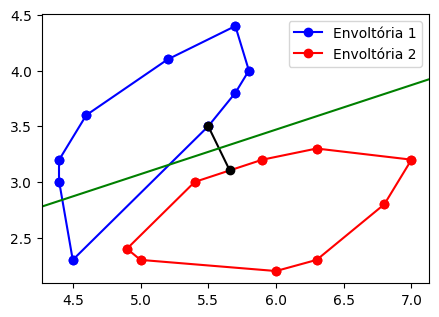

In [256]:
# Plota as envoltórias
fig, ax = plotarParDeEnvoltorias(env1, env2)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Plota o segmento de menor distância entre as envoltórias
ax.plot([pontosMaisProximos.esquerda.x, pontosMaisProximos.direita.x],
        [pontosMaisProximos.esquerda.y, pontosMaisProximos.direita.y], 'ko-')

# Plota a reta que separa as envoltórias
x = np.linspace(xlim[0], xlim[1], 1000)
ax.plot(x, yR_perpendicular(x), 'g')

print("Função da reta: " + str(r_perpendicular.a) + "x + " + str(r_perpendicular.b))

ax.legend()
plt.show()

# Parte 5
O classificador utiliza a reta de classificação definida na parte anterior para classificar o novo ponto, calculando se o ponto está abaixo ou acima da reta de classificação e qual das classes está acima ou abaixo dessa reta.

In [257]:
# Função que determina se um ponto está acima de uma reta
def estaAcimaDaReta(ponto, reta):
  f = funcaoDaReta(reta)
  if f(ponto.x) < ponto.y:
    return True
  return False

In [258]:
# Define qual das envoltórias está acima da reta
if (estaAcimaDaReta(pontosMaisProximos.direita, r_perpendicular) and
    pontosMaisProximos.direita == pontoD):
  classeAcima = 2
else:
  classeAcima = 1

In [259]:
# Cria os vetores de labels e guesses com os valores correto e os valores
# determinados pelo classificador
labels = []
guesses = []

for row in test.iterrows():
  if list(row)[1][2] == classe1:
    labels.append(True)
  elif list(row)[1][2] == classe2:
    labels.append(False)
  else:
    continue

  if estaAcimaDaReta(Ponto(list(row)[1][0], list(row)[1][1]), r_perpendicular):
    guesses.append(classeAcima == 1)
  else:
    guesses.append(classeAcima == 2)

# Parte 6
As métricas de classificação são calculadas utilizando as funções da biblioteca Scikit-Learn. O vetor de labels possui a classe correta dos pontos, definida no arquivo base, e o vetor de guesses possui a resposta que nosso classificador atribuiu a cada ponto.

# Experimento 2 - Global Temperatures data set

In [260]:
# Calcula as métricas de classificação
print('Precisão:', precision_score(labels, guesses))
print('Revocação:', recall_score(labels, guesses))
print('f1-escore:', f1_score(labels, guesses))

Precisão: 1.0
Revocação: 1.0
f1-escore: 1.0


In [261]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/global_temps.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18]], axis=1, inplace=True)
df.to_numpy()

# Definição de uma coluna a mais com a variação da temperatura com relação ao ano
# anterior para separação em duas classes
df['Annual_Temperature_Variation'] = df['J-D'].diff()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] >= 0:
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] < 0:
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [262]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

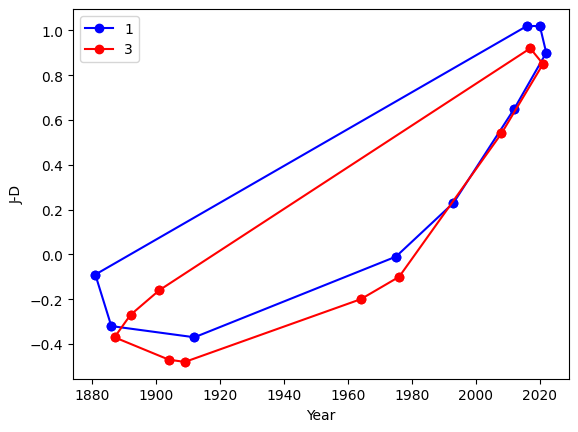

In [263]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = '1')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = '3')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("Year")
plt.ylabel("J-D")
plt.legend()
plt.show()

In [264]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [265]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados não linearmente separáveis


# Experimento 3 - Cancer data set

In [266]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/cancer.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[0,4,6,5,7,8,9,10,11,12,13,14,15]], axis=1, inplace=True)

# Reordenação das colunas
df = df[['Radius (mean)','Texture (mean)', 'Diagnosis']]
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] == "B":
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == "M":
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [267]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

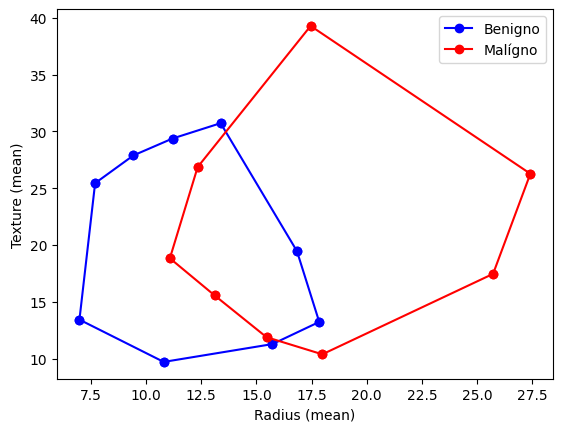

In [268]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = 'Benigno')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = 'Malígno')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("Radius (mean)")
plt.ylabel("Texture (mean)")
plt.legend()
plt.show()

In [269]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [270]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados não linearmente separáveis


# Experimento 4 - Wine data set

In [271]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/wine.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[1,2,3,4,5,7,8,9,10,11,12]], axis=1, inplace=True)
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []

classe1 = 1
classe2 = 3

for row in train.iterrows():
  if list(row)[1][2] == classe1:
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == classe2:
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [272]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

print(len(env1), len(env2))

8 6


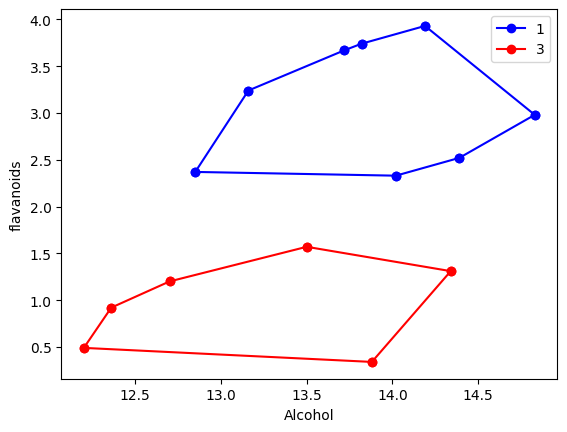

In [273]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = '1')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = '3')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("Alcohol")
plt.ylabel("flavanoids")
plt.legend()
plt.show()

In [274]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [275]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados linearmente separáveis


In [276]:
# Encontra os vértices de menor distância entre as envoltórias
segmento_min, indice_min_env1, indice_min_env2 = encontrarVerticesMaisProximos(env1, env2, plotar=False)

In [277]:
# Encontra os pontos na envoltória que compartilham lado com os vértices mais
# próximos de cada envoltória

if indice_min_env1 == 0:
  indice_prev_env1 = len(env1)-1
else:
  indice_prev_env1 = indice_min_env1-1

if indice_min_env1 == len(env1)-1:
  indice_next_env1 = 0
else:
  indice_next_env1 = indice_min_env1+1

if indice_min_env2 == 0:
  indice_prev_env2 = len(env2)-1
else:
  indice_prev_env2 = indice_min_env2-1

if indice_min_env2 == len(env2)-1:
  indice_next_env2 = 0
else:
  indice_next_env2 = indice_min_env2+1

In [278]:
# Encontra os pontos logo acima e logo abaixo dos pontos mais próximos entre as
# envoltórias

pontoA = env1[indice_min_env1]
pontoB = env1[indice_prev_env1]
pontoC = env1[indice_next_env1]
pontoD = env2[indice_min_env2]
pontoE = env2[indice_prev_env2]
pontoF = env2[indice_next_env2]

print('A', pontoA.x, pontoA.y)
print('B', pontoB.x, pontoB.y)
print('C', pontoC.x, pontoC.y)

print('D', pontoD.x, pontoF.y)
print('E', pontoE.x, pontoE.y)
print('F', pontoF.x, pontoF.y)

A 14.02 2.33
B 12.85 2.37
C 14.39 2.52
D 13.5 1.2
E 14.34 1.31
F 12.7 1.2


In [279]:
# Verifica os pontos mais proximos entre as envoltórias

# Distância entre os dois vértices mais próximos entre as envoltórias
distanciaVerticesMaisProximos = distancia(pontoA, pontoD)
pontosMaisProximos = Segmento(pontoA, pontoD)
menorDistancia = distanciaVerticesMaisProximos

# Altura do triangulo ABD
rAB = retaDoSegmento(Segmento(pontoA, pontoB))
rAB_perpendicular = retaPerpendicular(rAB, pontoD)
yRAB_perpendicular = funcaoDaReta(rAB_perpendicular)
pAB = pontoDeIntersecao(rAB, rAB_perpendicular)
alturaABD = distancia(pAB, pontoD)

if alturaABD < menorDistancia and noSegmento(pontoA, pontoB, pAB):
  menorDistancia = alturaABD
  pontosMaisProximos = Segmento(pAB, pontoD)

# Altura do triangulo ACD
rAC = retaDoSegmento(Segmento(pontoA, pontoC))
rAC_perpendicular = retaPerpendicular(rAC, pontoD)
yRAC_perpendicular = funcaoDaReta(rAC_perpendicular)
pAC = pontoDeIntersecao(rAC, rAC_perpendicular)
alturaACD = distancia(pAC, pontoD)

if alturaACD < menorDistancia and noSegmento(pontoA, pontoC, pAC):
  menorDistancia = alturaACD
  pontosMaisProximos = Segmento(pAC, pontoD)

# Altura do triangulo ADE
rDE = retaDoSegmento(Segmento(pontoD, pontoE))
rDE_perpendicular = retaPerpendicular(rDE, pontoA)
yRDE_perpendicular = funcaoDaReta(rDE_perpendicular)
pDE = pontoDeIntersecao(rDE, rDE_perpendicular)
alturaADE = distancia(pDE, pontoA)

if alturaADE < menorDistancia and noSegmento(pontoD, pontoE, pDE):
  menorDistancia = alturaADE
  pontosMaisProximos = Segmento(pDE, pontoA)

# Altura do triangulo ADF
rDF = retaDoSegmento(Segmento(pontoD, pontoF))
rDF_perpendicular = retaPerpendicular(rDF, pontoA)
yRDF_perpendicular = funcaoDaReta(rDF_perpendicular)
pDF = pontoDeIntersecao(rDF, rDF_perpendicular)
alturaADF = distancia(pDF, pontoA)

if alturaADF < menorDistancia and noSegmento(pontoD, pontoF, pDF):
  menorDistancia = alturaADF
  pontosMaisProximos = Segmento(pDF, pontoA)

In [280]:
# Reta r que contém o segmento de menor distância entre duas envoltórias
r = retaDoSegmento(pontosMaisProximos)

# Ponto médio do segmento de menor distância entre duas envoltórias
p = Ponto((pontosMaisProximos.esquerda.x + pontosMaisProximos.direita.x)/2,
          (pontosMaisProximos.esquerda.y + pontosMaisProximos.direita.y)/2)

# Reta r' perpendicular a r
r_perpendicular = retaPerpendicular(r, p)

# Função da reta r
yR_perpendicular = funcaoDaReta(r_perpendicular)

Função da reta: -0.03418803418803293x + 2.4204273504273335


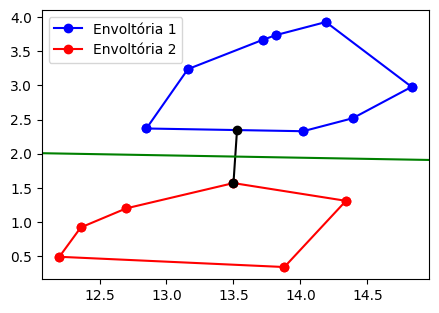

In [281]:
# Plota as envoltórias
fig, ax = plotarParDeEnvoltorias(env1, env2)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Plota o segmento de menor distância entre as envoltórias
ax.plot([pontosMaisProximos.esquerda.x, pontosMaisProximos.direita.x],
        [pontosMaisProximos.esquerda.y, pontosMaisProximos.direita.y], 'ko-')

# Plota a reta que separa as envoltórias
x = np.linspace(xlim[0], xlim[1], 1000)
ax.plot(x, yR_perpendicular(x), 'g')

print("Função da reta: " + str(r_perpendicular.a) + "x + " + str(r_perpendicular.b))

ax.legend()
plt.show()

In [282]:
# Define qual das envoltórias está acima da reta
if (estaAcimaDaReta(pontosMaisProximos.direita, r_perpendicular) and
    pontosMaisProximos.direita == pontoD):
  classeAcima = 2
else:
  classeAcima = 1

In [283]:
# Cria os vetores de labels e guesses com os valores correto e os valores
# determinados pelo classificador
labels = []
guesses = []

for row in test.iterrows():
  if list(row)[1][2] == classe1:
    labels.append(True)
  elif list(row)[1][2] == classe2:
    labels.append(False)
  else:
    continue

  if estaAcimaDaReta(Ponto(list(row)[1][0], list(row)[1][1]), r_perpendicular):
    guesses.append(classeAcima == 1)
  else:
    guesses.append(classeAcima == 2)

In [284]:
# Calcula as métricas de classificação
print('Precisão:', precision_score(labels, guesses))
print('Revocação:', recall_score(labels, guesses))
print('f1-escore:', f1_score(labels, guesses))

Precisão: 1.0
Revocação: 1.0
f1-escore: 1.0


# Experimento 5 - Appendicitis data set

In [285]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/pima.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[1,2,3,4,5,7]], axis=1, inplace=True)
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] == 'tested_positive':
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == 'tested_negative':
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [286]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

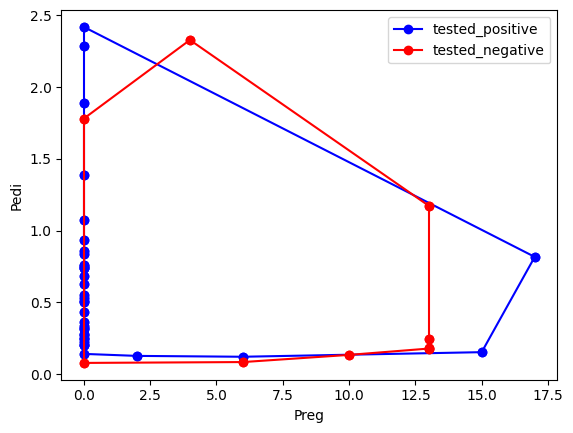

In [287]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = 'tested_positive')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = 'tested_negative')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("Preg")
plt.ylabel("Pedi")
plt.legend()
plt.show()

In [288]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [289]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados não linearmente separáveis


# Experimento 6 - South African Hearth data set

In [290]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/saheart.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[0,1,2,4,6,7,8]], axis=1, inplace=True)
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] == 1:
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == 0:
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [291]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

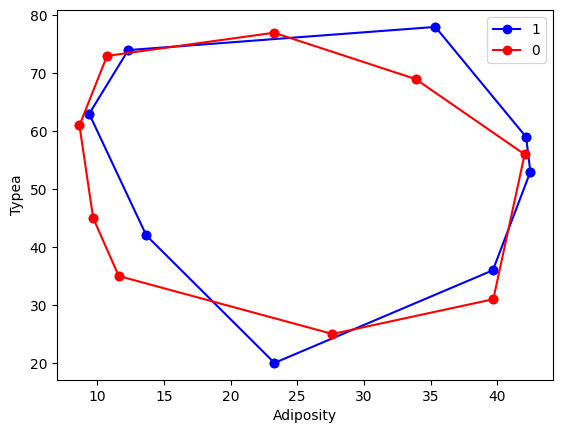

In [292]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = '1')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = '0')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("Adiposity")
plt.ylabel("Typea")
plt.legend()
plt.show()

In [293]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [294]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados não linearmente separáveis


# Experimento 7 - MAGIC Gamma Telescope data set

In [295]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/magic.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[2,3,4,5,6,7,8,9]], axis=1, inplace=True)
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] == 'g':
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == 'h':
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [296]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

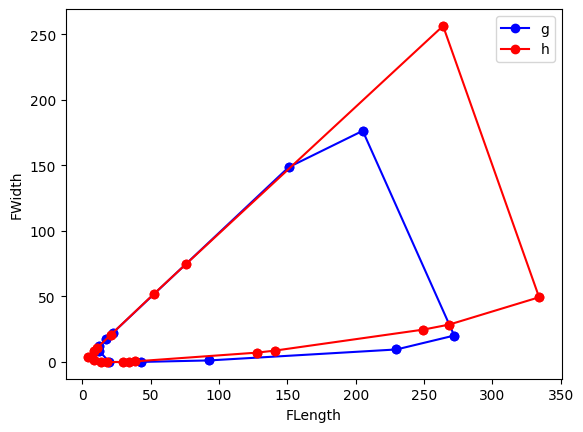

In [297]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = 'g')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = 'h')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("FLength")
plt.ylabel("FWidth")
plt.legend()
plt.show()

In [298]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [299]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados não linearmente separáveis


# Experimento 8 - Haberman's Survival data set

In [300]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/haberman.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[1]], axis=1, inplace=True)
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] == ' negative':
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == ' positive':
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [301]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

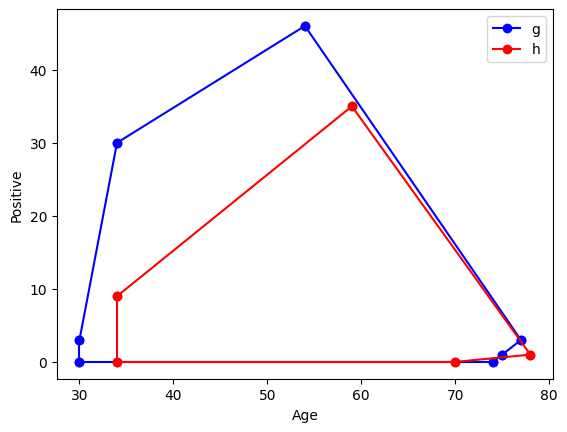

In [302]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = 'g')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = 'h')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("Age")
plt.ylabel("Positive")
plt.legend()
plt.show()

In [303]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [304]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados não linearmente separáveis


# Experimento 9 - Phoneme data set

In [305]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/phoneme.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[2,3,4]], axis=1, inplace=True)
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] == 0:
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == 1:
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [306]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

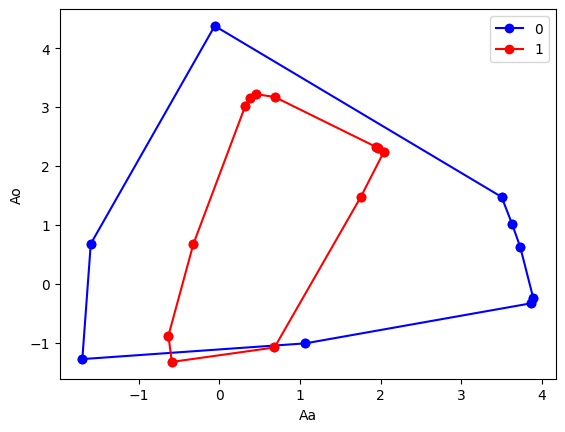

In [307]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = '0')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = '1')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("Aa")
plt.ylabel("Ao")
plt.legend()
plt.show()

In [308]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [309]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados não linearmente separáveis


# Experimento 10 - Liver Disorders (BUPA) data set

In [310]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/bupa.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[1,2,3,4]], axis=1, inplace=True)
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] == 1:
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == 2:
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [311]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

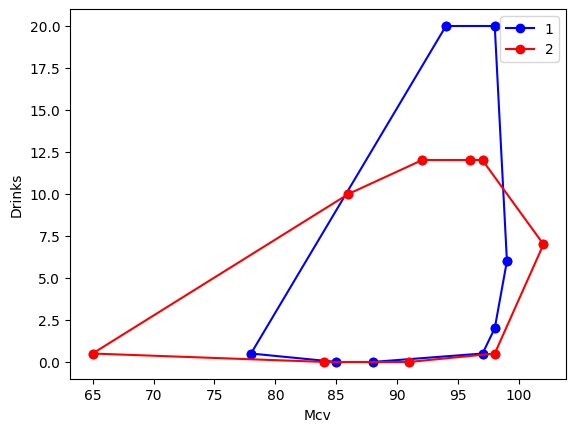

In [312]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = '1')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = '2')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("Mcv")
plt.ylabel("Drinks")
plt.legend()
plt.show()

In [313]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [314]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados linearmente separáveis


# Experimento 11 - Titanic data set

In [315]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/titanic.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[2]], axis=1, inplace=True)
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] == -1:
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == 1:
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [316]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

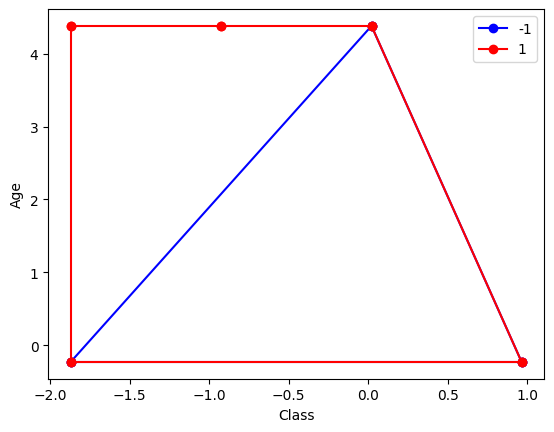

In [317]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = '-1')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = '1')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("Class")
plt.ylabel("Age")
plt.legend()
plt.show()

In [318]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [319]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados não linearmente separáveis


# Experimento 12 - Pima Indians Diabetes data set

In [320]:
# Le o arquivo com os dados
df = pd.read_csv('/content/sample_data/pima.csv')
# Seleciona as colunas de interesse
df.drop(df.columns[[0,1,4,5,6,7]], axis=1, inplace=True)
df.to_numpy()

# Separa os dados de teste em proporção de 70% para o treinamento e 30% para o teste
train, test = train_test_split(df, train_size=0.7)

# Cria os objetos da classe Ponto a partir dos atributos escolhidos
pontos1 = []
pontos2 = []
for row in train.iterrows():
  if list(row)[1][2] == 'tested_positive':
    pontos1.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))
  elif list(row)[1][2] == 'tested_negative':
    pontos2.append(Ponto(float(list(row)[1][0]), float(list(row)[1][1])))

In [321]:
# Encontra a envoltória convexa dos pontos da classe1 e classe2
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

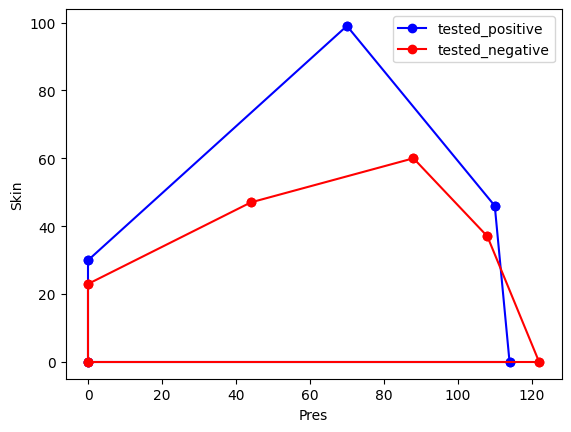

In [322]:
# Plota as envoltórias encontradas
plt.plot([env1[0].x, env1[len(env1)-1].x], [env1[0].y, env1[len(env1)-1].y], 'bo-', label = 'tested_positive')
for i in range(1, len(env1)):
  plt.plot([env1[i].x, env1[i-1].x], [env1[i].y, env1[i-1].y], 'bo-')

plt.plot([env2[0].x, env2[len(env2)-1].x], [env2[0].y, env2[len(env2)-1].y], 'ro-', label = 'tested_negative')
for i in range(1, len(env2)):
  plt.plot([env2[i].x, env2[i-1].x], [env2[i].y, env2[i-1].y], 'ro-')

plt.xlabel("Pres")
plt.ylabel("Skin")
plt.legend()
plt.show()

In [323]:
# Encontra os segmentos que compoem as envoltórias convexas
segmentos1 = segmentosDaEnvoltoria(env1)
segmentos2 = segmentosDaEnvoltoria(env2)

# Cria um array de eventos com a ordem de serem inseridos ou removidos na
# varredura linear
eventos = criarEventos(segmentos1, segmentos2)

In [324]:
# Verifica separabilidade linear dos dados
if intersecaoEmConjunto(eventos):
  print('Dados não linearmente separáveis')
else:
  print('Dados linearmente separáveis')

Dados não linearmente separáveis
